# generate_APWPs.py

this notebook allows the generation of apparent polar wander paths from dataframes of paleomagnetic poles and virtual geomagnetic poles

In [1]:
import os
import numpy as np
import pandas as pd
from pmagpy import ipmag, pmag
from collections import Counter
import scripts.auxiliar as aux

import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sb
import cartopy.crs as ccrs

pd.set_option('display.max_columns', None)

### Import data compilation
Compilations can be made with the build_compilation notebook.

In [2]:
current_path = os.getcwd()
data_path_VGP = current_path + '/vgp_database/compilations'
files_names = aux.get_files_in_directory(data_path_VGP)

xlsx_file_names = [os.path.splitext(os.path.basename(open(file,'r').name))[0] for file in files_names if file.endswith('.xlsx')]
paths = [file for file in files_names if file.endswith('.xlsx')] 
df_files = pd.DataFrame({'path': paths, 'name': xlsx_file_names})
df_files[['name']]

,name
0,test_compilation


Select a compilation to work with

In [3]:
file_idx = 0

<em> This next block will need to be revised according to how we decide to structure the compiled pole/vgp dataframes </em>

In [4]:
df_poles = pd.read_excel(df_files['path'][file_idx], sheet_name='poles')
df_vgps = pd.read_excel(df_files['path'][file_idx], sheet_name='vgps')

#cast columns
df_poles = df_poles.astype({'pole': int, 'N': int, 'Plat':float, 'Plon':float, 'A95':float, 'mean_age':float})
df_vgps = df_vgps.astype({'rev_VGP_lat':float, 'rev_VGP_lon':float, 'mean_age':float})

#### Sort data by mean age and assign a pole-id which will be useful later

In [5]:
df_poles.sort_values(by='mean_age', ascending=True, inplace=True)
df_poles.reset_index(drop=True, inplace=True)
df_poles['AgeIdx'] = np.arange(df_poles.shape[0])

# APWP construction:
In the following, we compute APWPs according to three different approaches (<em> although can also add splines...</em>):
##### <em> 1. Moving average using poles </em>
##### <em> 2. Moving average using parametrically resampled poles </em>
##### <em> 3. Moving average using non-parametrically resampled VGPs </em>

## 1. Moving average using poles

First have a look at the data and the plotted poles to ensure everything looks Ok.

In [6]:
df_poles.head()

,pole,name,slat,slon,N,dec,inc,k,alpha95,f_corr,Plat,Plon,K,A95,dp,dm,mean_age,min_age,2sig_min,max_age,2sig_max,uncer_dist,rock_typ_1,rock_typ_2,rock_typ_3,R1,R2.1,R2.2,R3,R4,R5.1,R5.2,R6,R7,pmag_ref,age_ref,pmag_comments,age_comments,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,AgeIdx
0,15,Michoacan_Guanajuato_volcanic_field,19.278857,257.651623,8,NaN,NaN,NaN,NaN,NaN,-83.095837,42.690352,31.322757,10.051793,NaN,NaN,0.3470,0.082,NaN,0.612,NaN,uniform,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,13,Long_Valley_Caldera_volcanics,NaN,NaN,20,NaN,NaN,NaN,NaN,NaN,-87.664063,11.142714,19.849724,7.512790,NaN,NaN,0.4075,0.064,NaN,0.751,NaN,uniform,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,30,Tequila_volcanic_field,20.832864,256.178936,17,NaN,NaN,NaN,NaN,NaN,-85.766587,264.438715,27.453724,6.931856,NaN,NaN,0.6225,0.115,NaN,1.130,NaN,uniform,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,33,Western_Central_TMVB,20.366391,257.543486,43,NaN,NaN,NaN,NaN,NaN,-87.850461,101.012479,28.976697,4.115853,NaN,NaN,1.2900,0.000,NaN,2.580,NaN,uniform,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
4,10,Eastern_TMVB,19.870126,261.479790,32,NaN,NaN,NaN,NaN,NaN,-83.266922,354.167250,24.995790,5.184285,NaN,NaN,1.2900,0.000,NaN,2.580,NaN,uniform,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4


### Plot the poles

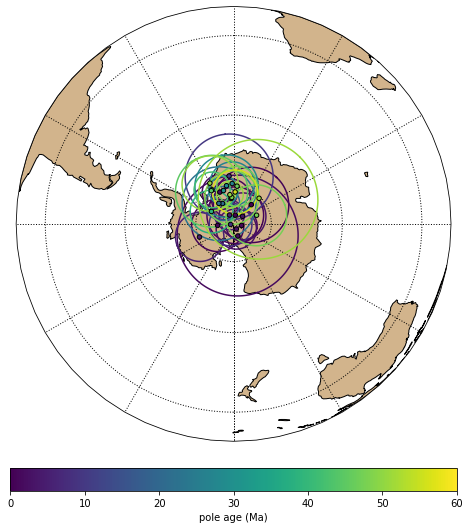

In [7]:
min_age = 0
max_age = 60
map_axis = ipmag.make_orthographic_map(central_longitude=0, central_latitude=-90, figsize=(10,10))
ipmag.plot_poles_colorbar(map_axis, df_poles.Plon, df_poles.Plat, df_poles.A95, df_poles.mean_age, min_age, max_age)
plt.show()

### Calculate running mean

Calculate running mean based on a specified window length and spacing.

In [8]:
def running_mean_APWP (data, plon_label, plat_label, age_label, window_length, time_step, max_age, min_age):
    
    mean_pole_ages = np.arange(min_age, max_age + time_step, time_step)
    
    running_means = pd.DataFrame(columns=['age','N','A95','plon','plat'])
    
    for age in mean_pole_ages:
        window_min = age - (window_length / 2.)
        window_max = age + (window_length / 2.)
        poles = data.loc[(data[age_label] >= window_min) & (data[age_label] <= window_max)]
        mean = ipmag.fisher_mean(dec=poles[plon_label].tolist(), inc=poles[plat_label].tolist())
        if mean: # this just ensures that dict isn't empty
            running_means.loc[age] = [age, mean['n'], mean['alpha95'], mean['dec'], mean['inc']]
    
    running_means.reset_index(drop=1, inplace=True)
    
    return running_means

In [9]:
window_length = 20
time_step = 10

RM_APWP = running_mean_APWP(df_poles, 'Plon', 'Plat', 'mean_age', window_length, time_step, max_age, min_age)
print (RM_APWP)

    age     N       A95        plon       plat
0   0.0  13.0  3.011488  343.247335 -87.550387
1  10.0  13.0  3.011488  343.247335 -87.550387
2  20.0   4.0  3.701754  343.963777 -81.780463
3  30.0   6.0  2.916102  338.045896 -82.147049
4  40.0   7.0  4.032849  344.505321 -82.700716
5  50.0   9.0  3.460127  355.796145 -82.096556
6  60.0   4.0  6.382432  359.815103 -81.549594


### Plot the running mean APWP

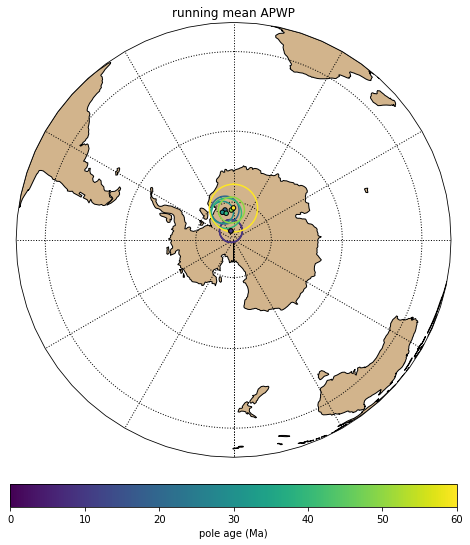

In [10]:
map_axis = ipmag.make_orthographic_map(central_longitude=0, central_latitude=-90, figsize=(10,10))
ipmag.plot_poles_colorbar(map_axis, RM_APWP.plon.tolist(), RM_APWP.plat.tolist(), 
                 RM_APWP.A95.tolist(), RM_APWP.age.tolist(), min_age, max_age)
plt.title('running mean APWP')
plt.show()

### Effective age distribution
It is useful to consider the effective age distribution of the data that we are working with here.

In [11]:
def plot_eff_age_dist (data, age_label, id_label, window_length, time_step, max_age, min_age):
    
    density_dict = {}
    mean_ages = np.arange(min_age, max_age + time_step, time_step)
    for age in mean_ages:
        window_min = age - (window_length / 2.)
        window_max = age + (window_length / 2.)
        density_dict[age] = Counter(data.loc[(data[age_label] >= window_min) & (data[age_label] <= window_max), id_label].tolist())

    fig = plt.figure(figsize=(10, 15))
    gridspec.GridSpec(4,1)
    
    plt.subplot2grid((4,1), (0,0), colspan=1, rowspan=3)
    elinew = 6
    for age, cntr in density_dict.items():
        for poleid, count in cntr.items():
            plt.errorbar(age, poleid+1, yerr=0, xerr=time_step/2., color='r', alpha=count/max(cntr.values()),
                         ecolor=None, elinewidth=elinew, capsize=0, capthick=0, ls='none', label=None, zorder=3)

    for _, row in data.iterrows():
        plt.scatter(row[age_label], row[id_label]+1, color='k', zorder=4)
    
    #plt.yticks(ticks=np.arange(1, data[id_label].max()+2), labels=data[id_label], zorder=1)
    plt.xlim(min_age, max_age)
    plt.xlabel('Age (Ma)')
    plt.grid(color='lightgrey', linestyle='--', linewidth=1, zorder=0) 
    plt.title('Effective age distribution...')

    ages, densities = [], []
    for age, cntr in density_dict.items():
        ages.append(int(age))
        densities.append(sum(cntr.values()))
    
    plt.subplot2grid((4,1), (3,0), colspan=1, rowspan=1)
    plt.bar(ages, densities, width=10, color='lightgrey', edgecolor='b', linewidth=1)
    plt.xlim(min_age, max_age)

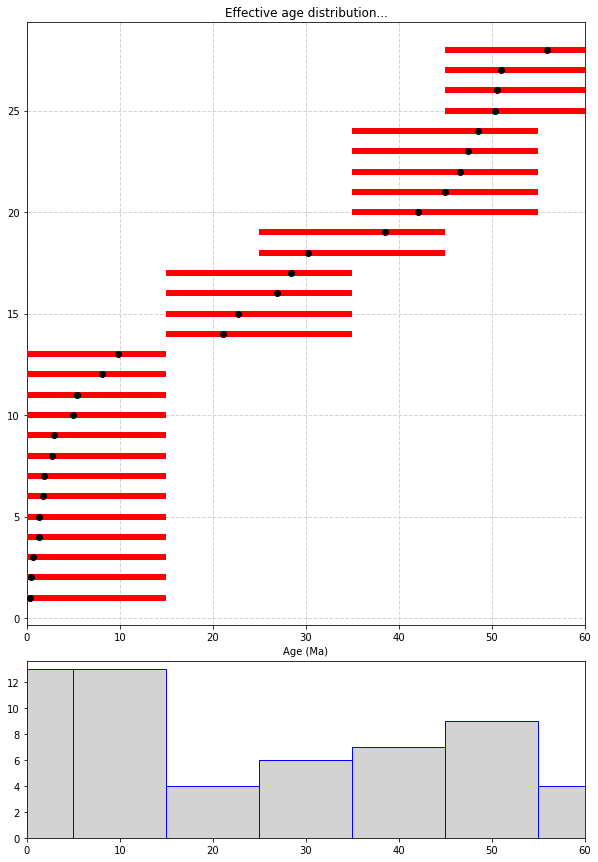

In [12]:
RM_APWP_age_res = plot_eff_age_dist (df_poles, 'mean_age', 'AgeIdx', window_length, time_step, max_age, min_age)

## 2. Moving average using parametrically resampled poles

First we need to generate a new dataset by drawing parametrically from the existing poles.

In [13]:
def parametric_bootstrap (data):

    poleIDs, age_draws, vgp_lon_draws, vgp_lat_draws = ([] for i in range(4))
    
    for _, ent in data.iterrows():
        
        bootstrap_vgps = ipmag.fishrot(k=ent.K, n=ent.N, dec=ent.Plon, inc=ent.Plat, di_block=False)
        vgp_lon_draws.append(bootstrap_vgps[0])
        vgp_lat_draws.append(bootstrap_vgps[1])
        N = len(bootstrap_vgps[0])
        
        if ent.uncer_dist == 'uniform':
            # first check if bounds of uniform range in fact have normally distributed errors
            
            if np.isnan(ent['2sig_min']): min_ages = [ent.min_age for _ in range(N)]
            else: min_ages = [np.random.normal(loc=ent.min_age, scale=(ent['2sig_min'])/2.) for _ in range(N)]   
            
            if np.isnan(ent['2sig_max']): max_ages = [ent.max_age for _ in range(N)]
            else: max_ages = [np.random.normal(loc=ent.max_age, scale=(ent['2sig_max'])/2.) for _ in range(N)]
            
            # grab uniform draws from range
            age_draws.append([np.random.uniform(min_ages[i], max_ages[i]) for i in range(N)])
            
        elif ent.uncer_dist == 'normal':
            # normal/gaussian draws
            age_draws.append([np.random.normal(loc=ent.mean_age, scale=(ent.max_age - ent.mean_age)/2.) for _ in range(N)]) 
        
        else: print ('unexpected age distribution type; cannot execute age bootstrap')
            
        poleIDs.append([ent.AgeIdx for _ in range(N)])

    bootstrap_data = {'pole_ID': [item for sublist in poleIDs for item in sublist],
                        'plat': [item for sublist in vgp_lat_draws for item in sublist],
                        'plon': [item for sublist in vgp_lon_draws for item in sublist],
                        'age':  [item for sublist in age_draws for item in sublist]}
    
    pseudo_vgps = pd.DataFrame(bootstrap_data)
    
    return pseudo_vgps

In [14]:
pseudo_vgps = parametric_bootstrap (df_poles)
pseudo_vgps

,pole_ID,plat,plon,age
0,0,-80.114746,158.264487,0.181190
1,0,-66.987496,136.901951,0.100307
2,0,-86.205470,59.299007,0.222330
3,0,-73.251641,39.725375,0.163250
4,0,-70.752370,187.056951,0.356846
...,...,...,...,...
903,27,-82.845644,144.677274,57.726269
904,27,-82.690753,83.267812,57.429576
905,27,-58.132090,279.608457,52.584631
906,27,-57.690619,38.189949,53.432171


### Plot the pseudo vgps (parametric draws from the poles)

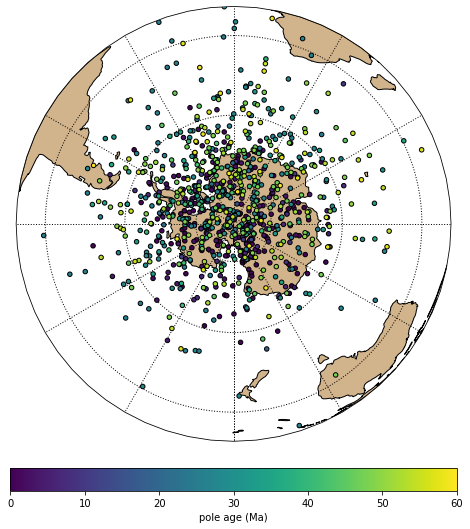

In [15]:
pseudo_vgps['A95'] = 0

map_axis = ipmag.make_orthographic_map(central_longitude=0, central_latitude=-90, figsize=(10,10))
ipmag.plot_poles_colorbar(map_axis, pseudo_vgps.plon, pseudo_vgps.plat, pseudo_vgps.A95, pseudo_vgps.age, 0, 60)
plt.show()

### Compute running means

In [16]:
RM_APWP_parametric = running_mean_APWP(pseudo_vgps, 'plon', 'plat', 'age', window_length, time_step, max_age, min_age)

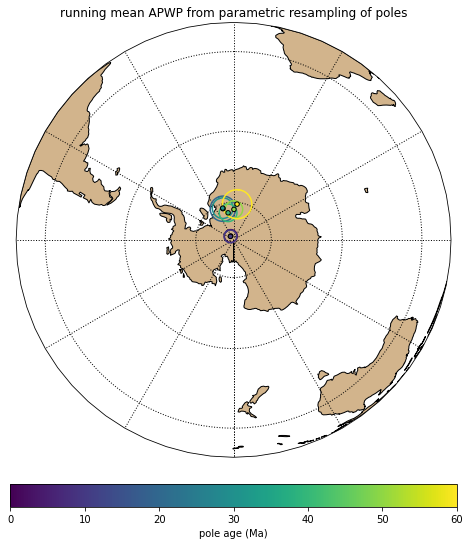

In [17]:
map_axis = ipmag.make_orthographic_map(central_longitude=0, central_latitude=-90, figsize=(10,10))
ipmag.plot_poles_colorbar(map_axis, RM_APWP_parametric.plon.tolist(), RM_APWP_parametric.plat.tolist(), 
                 RM_APWP_parametric.A95.tolist(), RM_APWP_parametric.age.tolist(), min_age, max_age)
plt.title('running mean APWP from parametric resampling of poles')
plt.show()

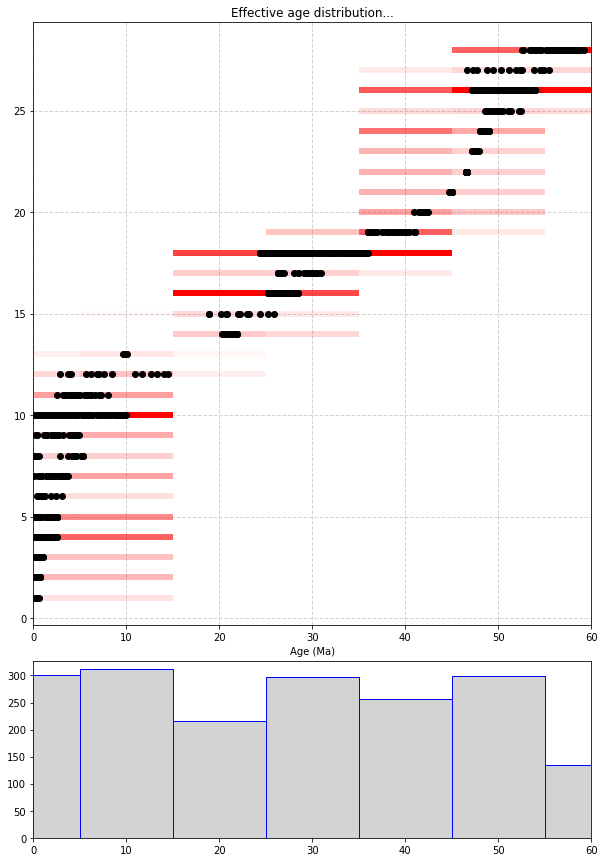

In [18]:
RM_APWP_age_res = plot_eff_age_dist (pseudo_vgps, 'age', 'pole_ID', window_length, time_step, max_age, min_age)

In [19]:
window_length = 20
time_step = 1
RM_APWP_parametric = running_mean_APWP(pseudo_vgps, 'plon', 'plat', 'age', window_length, time_step, max_age, min_age)

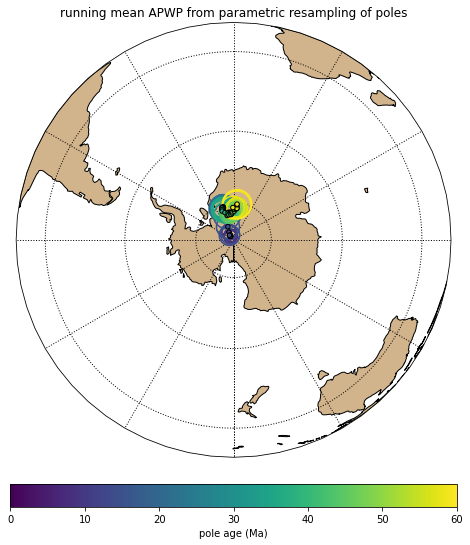

In [20]:
map_axis = ipmag.make_orthographic_map(central_longitude=0, central_latitude=-90, figsize=(10,10))
ipmag.plot_poles_colorbar(map_axis, RM_APWP_parametric.plon.tolist(), RM_APWP_parametric.plat.tolist(), 
                 RM_APWP_parametric.A95.tolist(), RM_APWP_parametric.age.tolist(), min_age, max_age)
plt.title('running mean APWP from parametric resampling of poles')
plt.show()

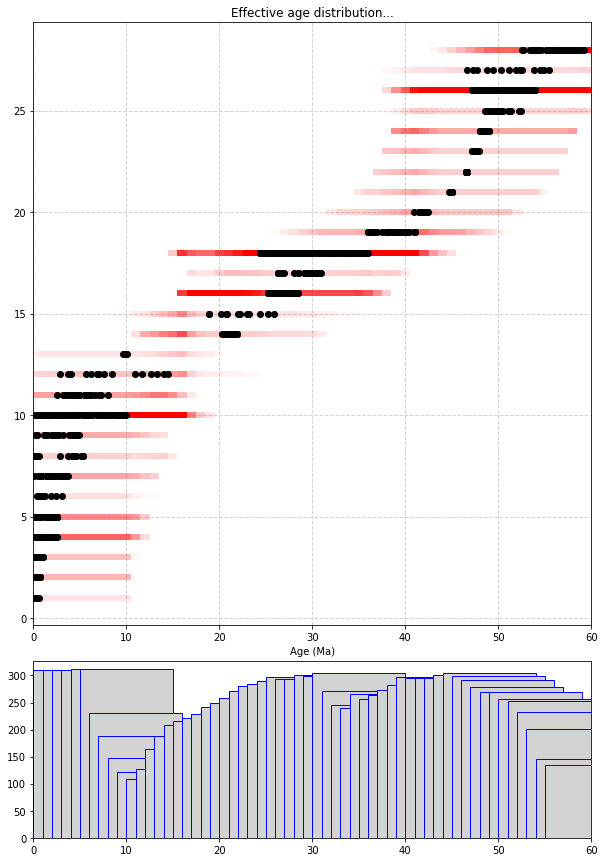

In [21]:
RM_APWP_age_res = plot_eff_age_dist (pseudo_vgps, 'age', 'pole_ID', window_length, time_step, max_age, min_age)

Over to VGPs now...

In [22]:
df_vgps.sort_values(by='mean_age', ascending=True, inplace=True)
df_vgps.reset_index(drop=True, inplace=True)
df_vgps['AgeIdx'] = np.arange(df_vgps.shape[0])

In [23]:
df_vgps.head()

,name,fm./loc.,slat,slon,n,dec,inc,k,alpha95,f_corr,VGP_lat,VGP_lon,K,A95,dp,dm,mean_age,min_age,2sig_min,max_age,2sig_max,uncer_dist,rock_typ_1,rock_typ_2,rock_typ_3,demag,struc_cont,rot_area,polarity,strat_group,ordering,synch_unit,in_study_pole,rej_crit,pmag_ref,age_ref,pmag_comments,age_comments,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,rev_VGP_lat,rev_VGP_lon,keep,AgeIdx
0,sr16,McKinney Basalt,42.888220,244.92279,7.0,347.4,65.6,227.9,4.0,NaN,79.900000,58.200000,NaN,NaN,NaN,NaN,0.052,0.028,NaN,0.076,NaN,normal,igneous,volcanic,NaN,NaN,NaN,NaN,N,0.0,NaN,0,1,0,Tauxe et al. (2004),Tauxe et al. (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,-79.900000,238.200000,True,0
1,1C684,Sawmill Creek basalt,36.910000,241.69000,8.0,0.4,70.2,248.0,3.5,NaN,72.600000,242.500000,NaN,NaN,NaN,NaN,0.053,0.009,NaN,0.097,NaN,normal,igneous,volcanic,basalt,NaN,NaN,NaN,N,0.0,NaN,0,1,0,Mankinen (2008),Mankinen (2008),NaN,NaN,NaN,NaN,NaN,NaN,NaN,-72.600000,62.500000,True,1
2,S46,Battleship Rock,35.860000,253.36000,9.0,358.3,43.2,317.0,2.9,NaN,79.200000,81.600000,NaN,NaN,NaN,NaN,0.055,0.050,NaN,0.060,NaN,uniform,igneous,volcanic,ash flow,NaN,NaN,NaN,N,1.0,2.0,0,1,0,Doell et al. (1968),Goff et al. (2011),NaN,NaN,NaN,NaN,NaN,NaN,NaN,-79.200000,261.600000,True,2
3,5L209,Long Valley Caldera - late basalts and trachya...,NaN,NaN,5.0,338.0,37.6,234.0,5.0,NaN,64.800000,116.300000,NaN,NaN,NaN,NaN,0.064,0.036,NaN,0.092,NaN,normal,igneous,volcanic,basalt,NaN,NaN,NaN,N,0.0,NaN,0,1,0,Mankinen et al. (1986),Mankinen et al. (1986),NaN,K-Ar ages not updated from 1986 standards,NaN,NaN,NaN,NaN,NaN,-64.800000,296.300000,True,3
4,Tan10 (NI 19),Tancitaro volcanics,19.164556,-102.21575,7.0,1.2,32.8,69.0,7.3,NaN,88.269224,36.486753,NaN,NaN,NaN,NaN,0.082,0.058,NaN,0.106,NaN,normal,igneous,volcanic,andesite,NaN,NaN,NaN,N,0.0,NaN,0,1,0,Maciel Peña et al. (2009),Maciel Peña et al. (2009),NaN,NaN,NaN,NaN,NaN,NaN,NaN,-88.269224,216.486753,True,4


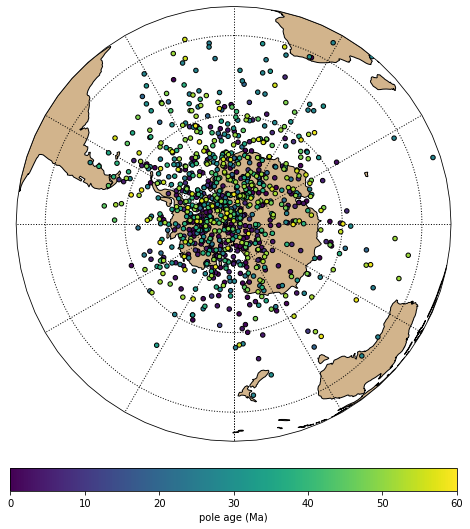

In [24]:
min_age = 0
max_age = 60
df_vgps['A95'] = 0
map_axis = ipmag.make_orthographic_map(central_longitude=0, central_latitude=-90, figsize=(10,10))
ipmag.plot_poles_colorbar(map_axis, df_vgps.rev_VGP_lon, df_vgps.rev_VGP_lat, df_vgps.A95, df_vgps.mean_age, min_age, max_age)
plt.show()

In [25]:
window_length = 20
time_step = 1

RM_APWP = running_mean_APWP(df_vgps, 'rev_VGP_lon', 'rev_VGP_lat', 'mean_age', window_length, time_step, max_age, min_age)
print (RM_APWP)

     age      N       A95        plon       plat
0    0.0  304.0  1.690477  331.771184 -87.889140
1    1.0  310.0  1.692206  333.409034 -87.827329
2    2.0  311.0  1.695412  332.005729 -87.907922
3    3.0  311.0  1.695412  332.005729 -87.907922
4    4.0  312.0  1.699535  331.233881 -87.811555
..   ...    ...       ...         ...        ...
56  56.0  234.0  2.572573    0.288503 -82.444521
57  57.0  234.0  2.572573    0.288503 -82.444521
58  58.0  217.0  2.697765  356.780662 -82.010353
59  59.0  201.0  2.780352  355.089871 -81.880837
60  60.0  178.0  3.027229  357.021688 -81.668393

[61 rows x 5 columns]


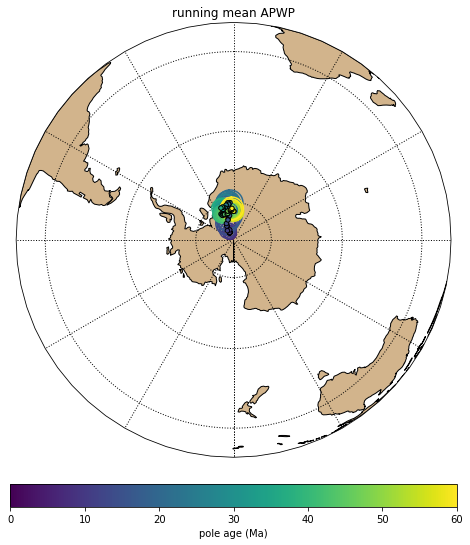

In [26]:
map_axis = ipmag.make_orthographic_map(central_longitude=0, central_latitude=-90, figsize=(10,10))
ipmag.plot_poles_colorbar(map_axis, RM_APWP.plon.tolist(), RM_APWP.plat.tolist(), 
                 RM_APWP.A95.tolist(), RM_APWP.age.tolist(), min_age, max_age)
plt.title('running mean APWP')
plt.show()

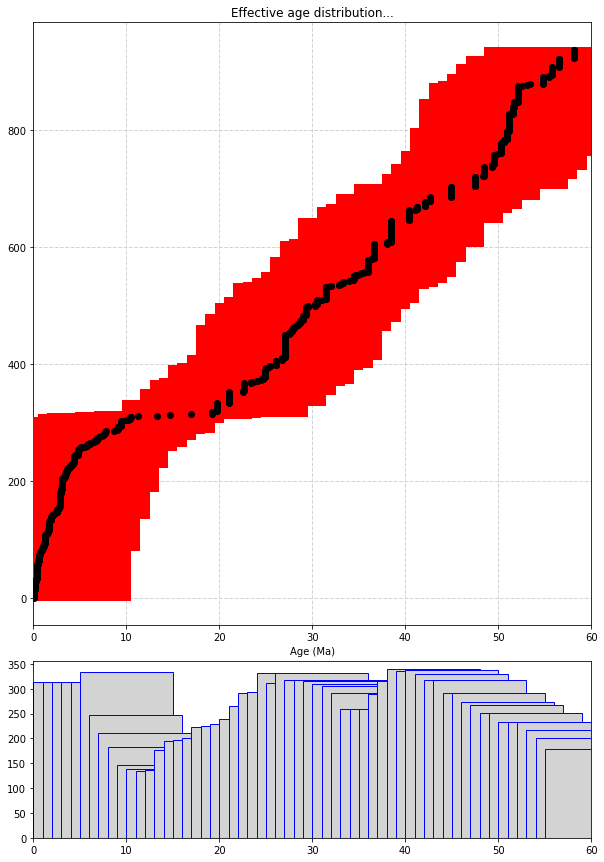

In [27]:
RM_APWP_age_res = plot_eff_age_dist (df_vgps, 'mean_age', 'AgeIdx', window_length, time_step, max_age, min_age)